# Проверка гипотез



In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest, pearsonr, linregress, spearmanr, kruskal, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.ticker as mtick

In [33]:
cian = pd.read_csv('/Users/issaya/PyCharmMiscProject/cian_processed.csv')
cian

,Цена_за_метр,Метро,Район,Этаж_квартиры,Этажность_здания,Площадь_помещения,Тип_недвижимости,seller_type,Документы_проверены,Супер_агент,...,Кол-во_комнат,Время_до_метро,floor_group,Центральный,Спальный,Прибрежный,Промышленный,Срочная_продажа,Группа_этажности,Ранг_метро
0,121023,Шушары,Пушкинский,7,9,50.780127,1,ПРЕДСТАВИТЕЛЬ ЗАСТРОЙЩИКА,0,0,...,1,2.40,[5-10],0,1,0,0,0,3,70
1,4124,Черная речка,Приморский,5,9,362.000000,1,АГЕНТСТВО НЕДВИЖИМОСТИ,1,0,...,1,10.00,[5-10],0,0,1,0,0,3,25
2,121118,Шушары,Колпинский,4,12,32.200000,1,АГЕНТСТВО НЕДВИЖИМОСТИ,1,0,...,1,3.15,[11-20],0,1,0,1,0,4,70
3,115113,Ладожская,Красногвардейский,1,5,46.400000,0,УК・ОФ.ПРЕДСТАВИТЕЛЬ,1,0,...,1,2.25,[5-10],0,1,0,0,0,3,3
4,122281,Проспект ветеранов,Красносельский,2,9,32.000000,1,АГЕНТСТВО НЕДВИЖИМОСТИ,1,0,...,1,1.80,[5-10],0,1,1,0,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28320,660000,Петроградская,Петроградский,6,6,102.372567,1,ЗАСТРОЙЩИК,0,0,...,0,16.00,[5-10],1,0,0,0,0,3,11
28321,521900,Балтийская,Адмиралтейский,2,9,62.319242,1,ЗАСТРОЙЩИК,0,0,...,0,4.00,[5-10],1,0,0,0,0,3,29
28322,155340,Гражданский проспект,Калининский,3,9,30.900000,1,РИЕЛТОР,0,1,...,0,0.90,[5-10],0,1,0,1,0,3,19
28323,166667,Проспект просвещения,Выборгский,1,12,32.100000,1,АГЕНТСТВО НЕДВИЖИМОСТИ,1,0,...,0,16.00,[11-20],0,1,0,0,0,4,9


### Чем выше этажность, тем ниже стоимость квадратного метра

  floor_group  cv_Цена_за_метр
0       [1-2]         0.507981
2       [3-4]         0.502967
3      [5-10]         0.695963
1     [11-20]         0.331563
4       [>20]         0.303782


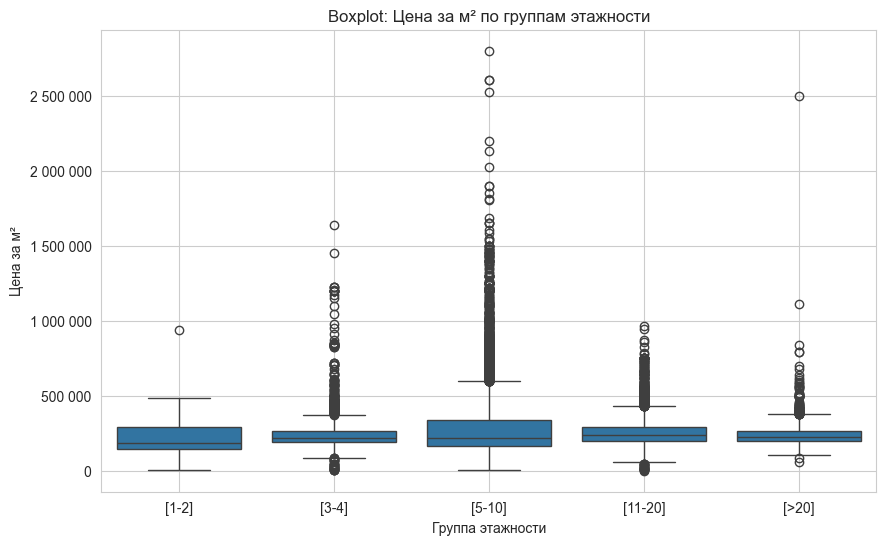

In [34]:
# Устанавливаем порядок сортировки групп этажности
order = ["[1-2]", "[3-4]", "[5-10]", "[11-20]", "[>20]"]

# Группировка количества этажей
stats = cian.groupby("floor_group")["Цена_за_метр"].agg(["mean", "std"]).reset_index()

# Упорядочиваем данные по группам этажности
stats["floor_group"] = pd.Categorical(stats["floor_group"], categories=order, ordered=True)
stats = stats.sort_values("floor_group")

# Добавляем коэффициент вариации (CV)
stats["cv_Цена_за_метр"] = stats["std"] / stats["mean"]

# Выводим таблицу с коэффициентом вариации
print(stats[["floor_group", "cv_Цена_за_метр"]])

# Построение boxplot с нормальными числами
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x="floor_group",
    y="Цена_за_метр",
    data=cian,
    order=order
)
plt.xlabel("Группа этажности")
plt.ylabel("Цена за м²")
plt.title("Boxplot: Цена за м² по группам этажности")
plt.grid(True)

# Убираем научную нотацию
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", " ")))

plt.show()

Boxplot показывает, что средняя цена по данным категориям этажности примерно совпадает, но для более низких зданий мы видим большую дисперсию, поэтому это нужно учитывать при дальнейшем анализе.
Диаграмма рассеяния также подтверждает тот факт, что высокое отклонение безусловно стоит принимать во внимание в дальнейшем.

Корреляция между этажностью здания и медианной ценой за м²: -0.18
P-value: 0.30544


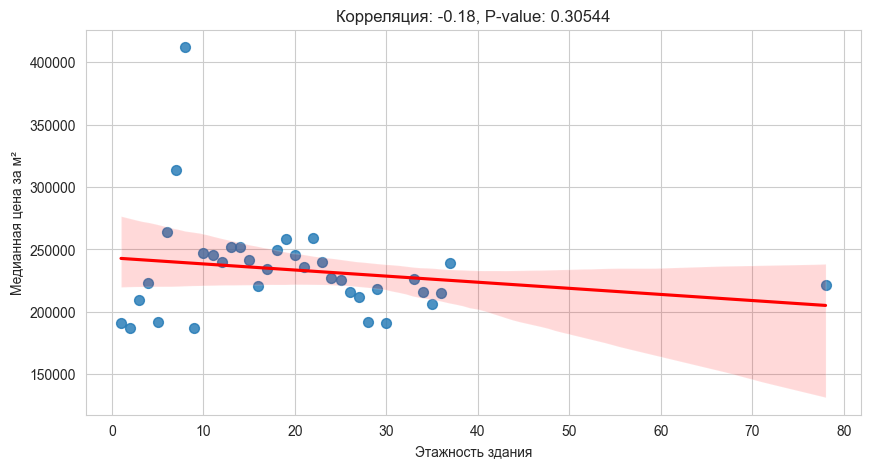

In [35]:
# Вычисляем медианную цену за м² для каждого этажа
median_prices = cian.groupby("Этажность_здания")["Цена_за_метр"].median().reset_index()
median_prices.rename(columns={"Цена_за_метр": "Медианная_цена_за_метр"}, inplace=True)

# Вычисляем корреляцию и p-value
correlation, p_value = pearsonr(median_prices["Этажность_здания"], median_prices["Медианная_цена_за_метр"])

print(f"Корреляция между этажностью здания и медианной ценой за м²: {correlation:.2f}")
print(f"P-value: {p_value:.5f}")

# Строим диаграмму рассеяния с трендовой линией
plt.figure(figsize=(10, 5))
sns.regplot(
    x=median_prices["Этажность_здания"],
    y=median_prices["Медианная_цена_за_метр"],
    scatter_kws={"s": 50},
    line_kws={"color": "red"}
)

plt.xlabel("Этажность здания")
plt.ylabel("Медианная цена за м²")
plt.title(f"Корреляция: {correlation:.2f}, P-value: {p_value:.5f}")
plt.grid(True)
plt.show()

Мы провели корреляционный анализ изменения медианной цены в зависимости от этажности. Диаграмма рассеяния показывает, что зависимости нет. Расчетная корреляция подтверждает вышесказанное. Также нужно отметить, что p-value очень высокий (0,27)

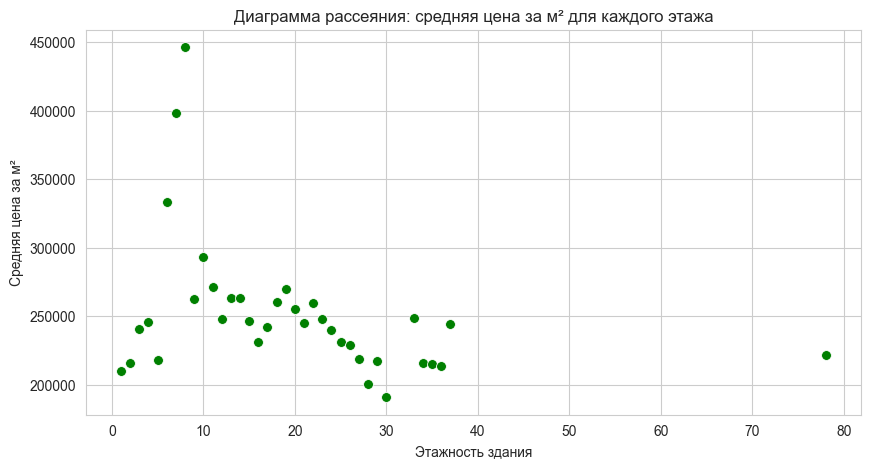

    Этажность_здания   Цена_за_метр
0                  1  210064.500000
1                  2  215772.978102
2                  3  240679.598485
3                  4  245706.424815
4                  5  217772.741119
5                  6  333466.055245
6                  7  398149.815005
7                  8  446309.307988
8                  9  262720.452090
9                 10  293494.354260
10                11  271532.982287
11                12  248120.650877
12                13  263474.960563
13                14  263265.415612
14                15  246775.589226
15                16  230922.319253
16                17  242273.739514
17                18  260340.391858
18                19  269505.704280
19                20  255222.013158
20                21  244843.754098
21                22  259735.556962
22                23  248204.291139
23                24  240129.490166
24                25  230863.323695
25                26  228846.866469
26                27  218618

In [36]:
# Считаем среднюю цену за м² для каждого этажа
mean_prices = cian.groupby("Этажность_здания")["Цена_за_метр"].mean().reset_index()

# Строим диаграмму рассеяния
plt.figure(figsize=(10, 5))
sns.scatterplot(x=mean_prices["Этажность_здания"], y=mean_prices["Цена_за_метр"], s=50, color="green")

plt.xlabel("Этажность здания")
plt.ylabel("Средняя цена за м²")
plt.title("Диаграмма рассеяния: средняя цена за м² для каждого этажа")
plt.grid(True)
plt.show()

# Выводим таблицу со средними ценами
print(mean_prices)

Для чистоты проверки гипотезы проверим, что средняя цена может ошибочно показывать тренд. На графике видим, что тренд определенно присутствует. Необходимо построение линии тренда и расчет корреляции.

Корреляция между этажностью здания и средней ценой за м²: -0.36
P-value: 0.02902


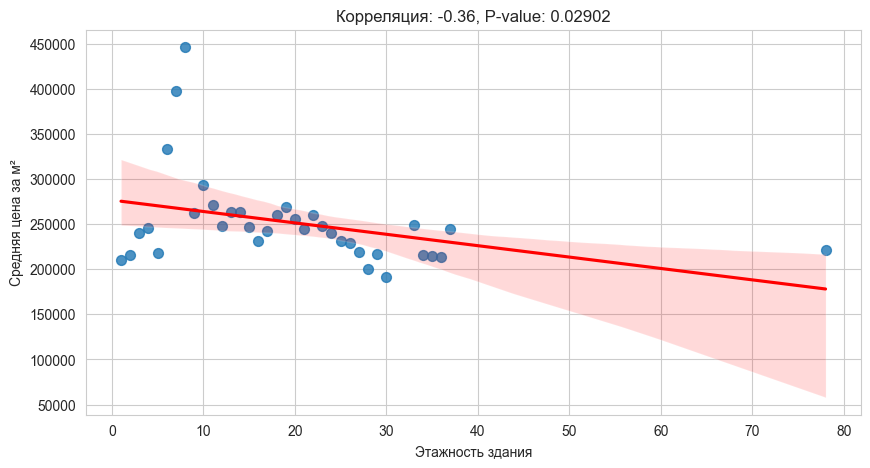

In [37]:
# Удаляем пропущенные значения
cian = cian.dropna(subset=["Этажность_здания", "Цена_за_метр"])

# Считаем среднюю цену за м² для каждого этажа
mean_prices = cian.groupby("Этажность_здания")["Цена_за_метр"].mean().reset_index()
mean_prices.rename(columns={"Цена_за_метр": "Средняя_цена_за_метр"}, inplace=True)

# Вычисляем корреляцию и p-value
correlation, p_value = pearsonr(mean_prices["Этажность_здания"], mean_prices["Средняя_цена_за_метр"])

print(f"Корреляция между этажностью здания и средней ценой за м²: {correlation:.2f}")
print(f"P-value: {p_value:.5f}")

# Строим диаграмму рассеяния с трендовой линией
plt.figure(figsize=(10, 5))
sns.regplot(x=mean_prices["Этажность_здания"], y=mean_prices["Средняя_цена_за_метр"], scatter_kws={"s": 50}, line_kws={"color": "red"})

plt.xlabel("Этажность здания")
plt.ylabel("Средняя цена за м²")
plt.title(f"Корреляция: {correlation:.2f}, P-value: {p_value:.5f}")
plt.grid(True)
plt.show()

Тестирование показало, что между средней ценой за квадратный метр и этажностью имеется умеренная зависимость.
Однако, учитывая, что дисперсия у нас достаточно высокая нам лучше оценивать при помощи медианной цены. Исходя из всего вышесказанного мы отвергаем гипотезу.

### Объявления со срочной продажей имеют более низкую цену

In [38]:
cian

,Цена_за_метр,Метро,Район,Этаж_квартиры,Этажность_здания,Площадь_помещения,Тип_недвижимости,seller_type,Документы_проверены,Супер_агент,...,Кол-во_комнат,Время_до_метро,floor_group,Центральный,Спальный,Прибрежный,Промышленный,Срочная_продажа,Группа_этажности,Ранг_метро
0,121023,Шушары,Пушкинский,7,9,50.780127,1,ПРЕДСТАВИТЕЛЬ ЗАСТРОЙЩИКА,0,0,...,1,2.40,[5-10],0,1,0,0,0,3,70
1,4124,Черная речка,Приморский,5,9,362.000000,1,АГЕНТСТВО НЕДВИЖИМОСТИ,1,0,...,1,10.00,[5-10],0,0,1,0,0,3,25
2,121118,Шушары,Колпинский,4,12,32.200000,1,АГЕНТСТВО НЕДВИЖИМОСТИ,1,0,...,1,3.15,[11-20],0,1,0,1,0,4,70
3,115113,Ладожская,Красногвардейский,1,5,46.400000,0,УК・ОФ.ПРЕДСТАВИТЕЛЬ,1,0,...,1,2.25,[5-10],0,1,0,0,0,3,3
4,122281,Проспект ветеранов,Красносельский,2,9,32.000000,1,АГЕНТСТВО НЕДВИЖИМОСТИ,1,0,...,1,1.80,[5-10],0,1,1,0,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28320,660000,Петроградская,Петроградский,6,6,102.372567,1,ЗАСТРОЙЩИК,0,0,...,0,16.00,[5-10],1,0,0,0,0,3,11
28321,521900,Балтийская,Адмиралтейский,2,9,62.319242,1,ЗАСТРОЙЩИК,0,0,...,0,4.00,[5-10],1,0,0,0,0,3,29
28322,155340,Гражданский проспект,Калининский,3,9,30.900000,1,РИЕЛТОР,0,1,...,0,0.90,[5-10],0,1,0,1,0,3,19
28323,166667,Проспект просвещения,Выборгский,1,12,32.100000,1,АГЕНТСТВО НЕДВИЖИМОСТИ,1,0,...,0,16.00,[11-20],0,1,0,0,0,4,9


In [39]:
cian['Срочная_продажа'].value_counts()

Срочная_продажа
0    28029
1      296
Name: count, dtype: int64

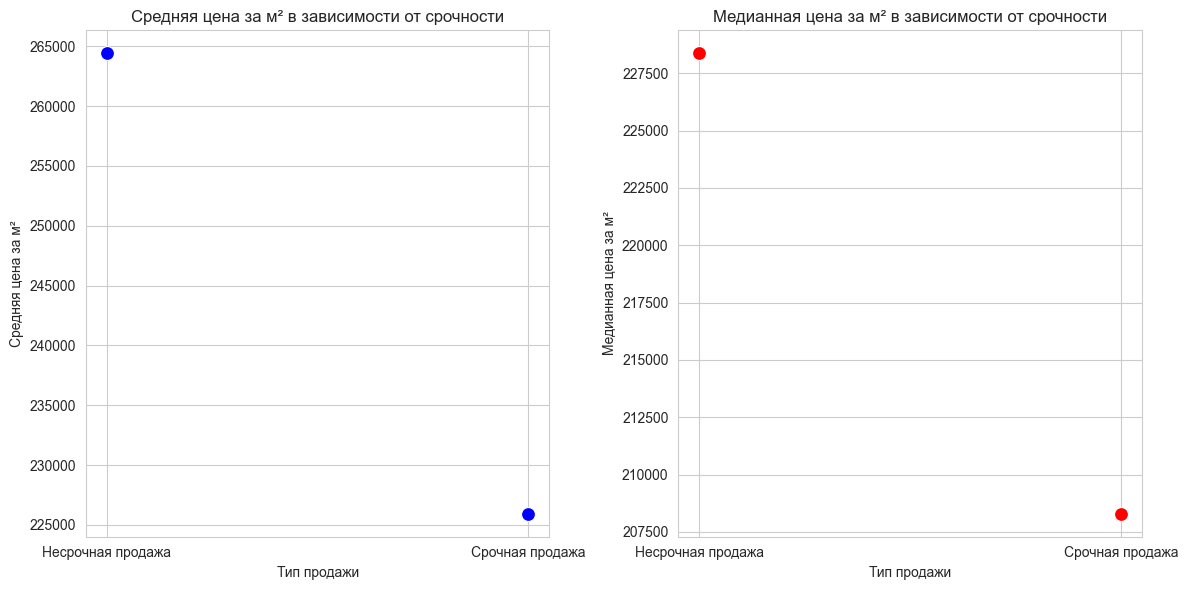

In [22]:
# Группировка данных: рассчитываем среднюю и медианную цену за м² для срочной и несрочной продажи
grouped_data = cian.groupby('Срочная_продажа')["Цена_за_метр"].agg(["mean", "median"]).reset_index()

# Переименовываем значения для графиков
grouped_data["Срочная_продажа"] = grouped_data["Срочная_продажа"].map({0: "Несрочная продажа", 1: "Срочная продажа"})

# Построение диаграммы рассеяния
plt.figure(figsize=(12, 6))

# График 1: Средняя цена
plt.subplot(1, 2, 1)
sns.scatterplot(x="Срочная_продажа", y="mean", data=grouped_data, s=100, color="blue")
plt.xlabel("Тип продажи")
plt.ylabel("Средняя цена за м²")
plt.title("Средняя цена за м² в зависимости от срочности")

# График 2: Медианная цена
plt.subplot(1, 2, 2)
sns.scatterplot(x="Срочная_продажа", y="median", data=grouped_data, s=100, color="red")
plt.xlabel("Тип продажи")
plt.ylabel("Медианная цена за м²")
plt.title("Медианная цена за м² в зависимости от срочности")

plt.tight_layout()
plt.show()

/var/folders/bm/39vh_d456d388sl7tv8xtz540000gn/T/ipykernel_47576/496010514.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cian['log_Цена_за_метр'] = np.log1p(cian['Цена_за_метр'])  # log1p безопасен для нулевых значений


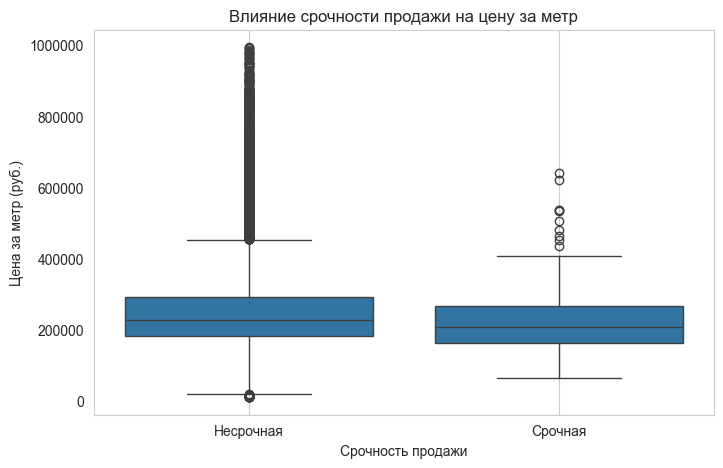

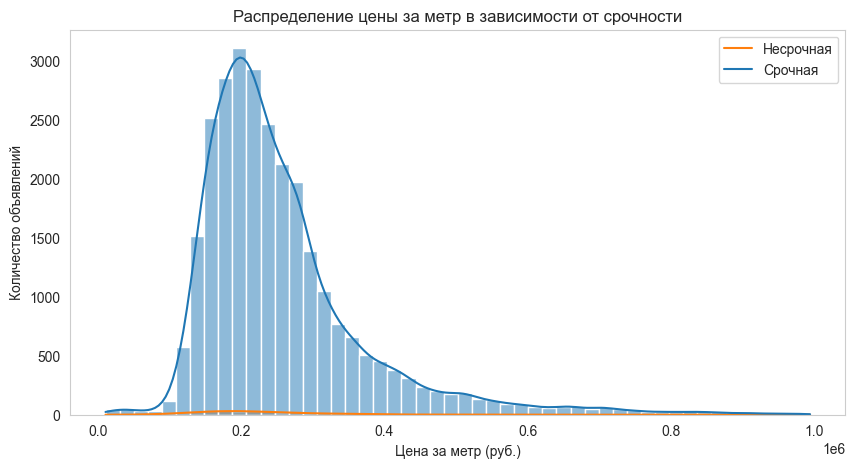

Статистика различий цен за метр по срочности продажи:
                   count           mean            std      min        25%  \
Срочная_продажа                                                              
0                27799.0  256977.381093  117948.678719  10412.0  182715.50   
1                  296.0  225936.716216   91156.871701  64212.0  162903.25   

                      50%        75%       max  
Срочная_продажа                                 
0                227603.0  291170.50  994500.0  
1                208290.5  267315.75  640635.0  

T-статистика: -5.81, p-value: 0.0000
Разница статистически значима: срочная продажа влияет на цену за метр.


In [23]:
# Убираем выбросы (если есть)
cian = cian[(cian['Цена_за_метр'] > 10_000) & (cian['Цена_за_метр'] < 1_000_000)]  # Фильтр адекватных значений

# Добавляем логарифм цены (чтобы сгладить разброс)
cian['log_Цена_за_метр'] = np.log1p(cian['Цена_за_метр'])  # log1p безопасен для нулевых значений

# Группируем данные и считаем среднюю цену за метр
price_by_urgency = cian.groupby('Срочная_продажа')['Цена_за_метр'].describe()

# Визуализация: Boxplot (цены в логарифмическом виде)

from matplotlib.ticker import ScalarFormatter

# Создаем график boxplot
plt.figure(figsize=(8, 5))
ax = sns.boxplot(x=cian['Срочная_продажа'], y=cian['Цена_за_метр'])

# Исправляем форматирование оси Y (убираем научную нотацию)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='y')  # Отображение обычных чисел

# Добавляем подписи
plt.xticks(ticks=[0, 1], labels=['Несрочная', 'Срочная'])
plt.xlabel('Срочность продажи')
plt.ylabel('Цена за метр (руб.)')
plt.title('Влияние срочности продажи на цену за метр')
plt.grid()
plt.show()
# Визуализация: Гистограмма распределения

plt.figure(figsize=(10, 5))
sns.histplot(cian, x="Цена_за_метр", hue="Срочная_продажа", bins=50, kde=True)
plt.xlabel("Цена за метр (руб.)")
plt.ylabel("Количество объявлений")
plt.title("Распределение цены за метр в зависимости от срочности")
plt.legend(["Несрочная", "Срочная"])
plt.grid()
plt.show()

# Статистический тест (t-тест)
urgent_prices = cian[cian['Срочная_продажа'] == 1]['Цена_за_метр']
non_urgent_prices = cian[cian['Срочная_продажа'] == 0]['Цена_за_метр']

t_stat, p_value = ttest_ind(urgent_prices, non_urgent_prices, equal_var=False)  # Welch’s t-test

# Вывод результатов
print("Статистика различий цен за метр по срочности продажи:")
print(price_by_urgency)
print(f"\nT-статистика: {t_stat:.2f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Разница статистически значима: срочная продажа влияет на цену за метр.")
else:
    print("Разница НЕ статистически значима: срочная продажа НЕ влияет на цену за метр.")
    


### Количество комнат и расстояние до метро

Гипотеза: Для квартир с <=3 комнат влияние удаленности от метро на цену выше, чем для квартир с большим количеством комнат

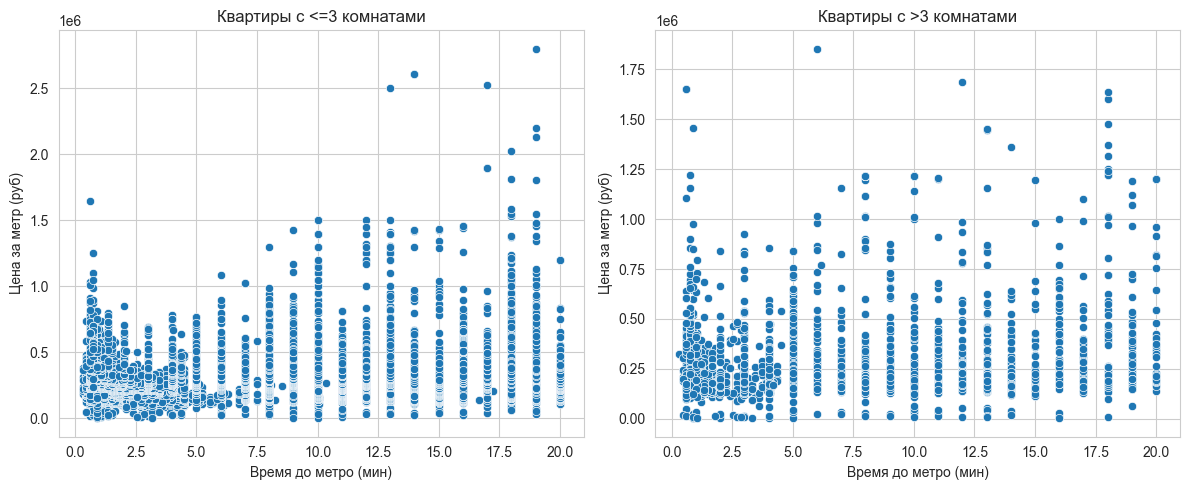

Для квартир с <=3 комнатами:
Корреляция Пирсона: 0.224
p-value: 0.000

Для квартир с >3 комнатами:
Корреляция Пирсона: 0.159
p-value: 0.000

Линейная регрессия:
Для <=3 комнат: наклон = 5180.43, p-value = 0.00000
Для >3 комнат: наклон = 6507.65, p-value = 0.00000


In [43]:
# Разделяем данные на две группы
small_rooms = cian[cian['Кол-во_комнат'] <= 3]  # <= 3 комнаты
large_rooms = cian[cian['Кол-во_комнат'] > 3]   # > 3 комнаты

# Построение графиков
plt.figure(figsize=(12, 5))

# График для квартир с <=3 комнатами
plt.subplot(1, 2, 1)
sns.scatterplot(x='Время_до_метро', y='Цена_за_метр', data=small_rooms)
plt.title('Квартиры с <=3 комнатами')
plt.xlabel('Время до метро (мин)')
plt.ylabel('Цена за метр (руб)')

# График для квартир с >3 комнатами
plt.subplot(1, 2, 2)
sns.scatterplot(x='Время_до_метро', y='Цена_за_метр', data=large_rooms)
plt.title('Квартиры с >3 комнатами')
plt.xlabel('Время до метро (мин)')
plt.ylabel('Цена за метр (руб)')

plt.tight_layout()
plt.show()

# Корреляция Пирсона и p-value для каждой группы
corr_small, pval_small = pearsonr(small_rooms['Время_до_метро'], small_rooms['Цена_за_метр'])
corr_large, pval_large = pearsonr(large_rooms['Время_до_метро'], large_rooms['Цена_за_метр'])

print("Для квартир с <=3 комнатами:")
print(f"Корреляция Пирсона: {corr_small:.3f}")
print(f"p-value: {pval_small:.3f}")

print("\nДля квартир с >3 комнатами:")
print(f"Корреляция Пирсона: {corr_large:.3f}")
print(f"p-value: {pval_large:.3f}")

# Линейная регрессия для оценки наклона зависимости
slope_small, intercept_small, r_small, p_small, stderr_small = linregress(small_rooms['Время_до_метро'], small_rooms['Цена_за_метр'])
slope_large, intercept_large, r_large, p_large, stderr_large = linregress(large_rooms['Время_до_метро'], large_rooms['Цена_за_метр'])

print("\nЛинейная регрессия:")
print(f"Для <=3 комнат: наклон = {slope_small:.2f}, p-value = {p_small:.5f}")
print(f"Для >3 комнат: наклон = {slope_large:.2f}, p-value = {p_large:.5f}")

### Загруженность станций и цена на квартиру

Гипотеза: Чем сильнее загружена ближайшая станция, тем ниже стоимость квадратного метра

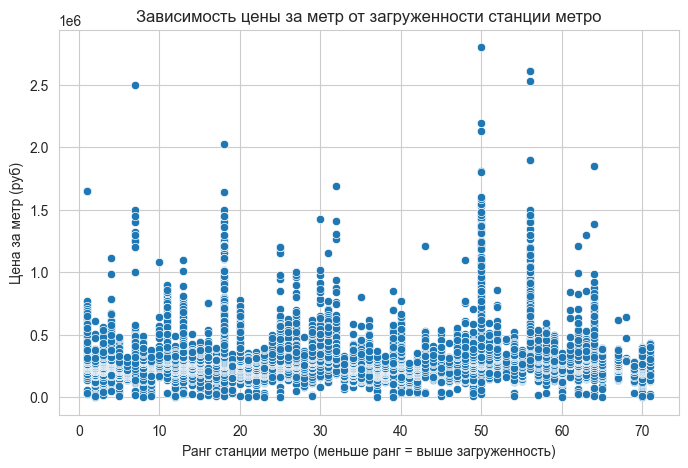

Корреляция:
Пирсон: корреляция = 0.176, p-value = 0.000
Спирмен: корреляция = 0.185, p-value = 0.000

Линейная регрессия:
Наклон = 1349.55, p-value = 0.000

Тест Краскела-Уоллиса (сравнение цен по группам загруженности):
Статистика = 1170.19, p-value = 0.000


In [44]:
cian_clean = cian.copy()
# Преобразуем 'Ранг_метро' в числовой формат, заменяя 'нет информации' на NaN
cian_clean['Ранг_метро'] = pd.to_numeric(cian_clean['Ранг_метро'], errors='coerce')

# Удаляем строки с NaN в 'Ранг_метро', чтобы анализировать только квартиры с известным рангом
cian_clean = cian_clean.dropna(subset=['Ранг_метро'])

# Построение графика
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Ранг_метро', y='Цена_за_метр', data=cian_clean)
plt.title('Зависимость цены за метр от загруженности станции метро')
plt.xlabel('Ранг станции метро (меньше ранг = выше загруженность)')
plt.ylabel('Цена за метр (руб)')
plt.show()

# Корреляция Пирсона и Спирмена
corr_pearson, pval_pearson = pearsonr(cian_clean['Ранг_метро'], cian_clean['Цена_за_метр'])
corr_spearman, pval_spearman = spearmanr(cian_clean['Ранг_метро'], cian_clean['Цена_за_метр'])

print("Корреляция:")
print(f"Пирсон: корреляция = {corr_pearson:.3f}, p-value = {pval_pearson:.3f}")
print(f"Спирмен: корреляция = {corr_spearman:.3f}, p-value = {pval_spearman:.3f}")

# Линейная регрессия
slope, intercept, r_value, p_value, stderr = linregress(cian_clean['Ранг_метро'], cian_clean['Цена_за_метр'])
print("\nЛинейная регрессия:")
print(f"Наклон = {slope:.2f}, p-value = {p_value:.3f}")

# Дополнительный тест: группируем станции по категориям загруженности
# Разделим на 3 группы: высокая загруженность (ранг 1-5), средняя (6-10), низкая (>10)
cian_clean['Загруженность'] = pd.cut(cian_clean['Ранг_метро'], 
                                     bins=[0, 5, 10, float('inf')], 
                                     labels=['Высокая', 'Средняя', 'Низкая'], 
                                     include_lowest=True)

# Тест Краскела-Уоллиса для сравнения цен между группами
high_load = cian_clean[cian_clean['Загруженность'] == 'Высокая']['Цена_за_метр']
med_load = cian_clean[cian_clean['Загруженность'] == 'Средняя']['Цена_за_метр']
low_load = cian_clean[cian_clean['Загруженность'] == 'Низкая']['Цена_за_метр']

# Убедимся, что в каждой группе есть данные
if len(high_load) > 0 and len(med_load) > 0 and len(low_load) > 0:
    kruskal_stat, kruskal_pval = kruskal(high_load, med_load, low_load)
    print("\nТест Краскела-Уоллиса (сравнение цен по группам загруженности):")
    print(f"Статистика = {kruskal_stat:.2f}, p-value = {kruskal_pval:.3f}")
else:
    print("\nТест Краскела-Уоллиса не выполнен: недостаточно данных в одной из групп.")

### Чем выше этажность квартиры, тем стоимость квадратного метра выше

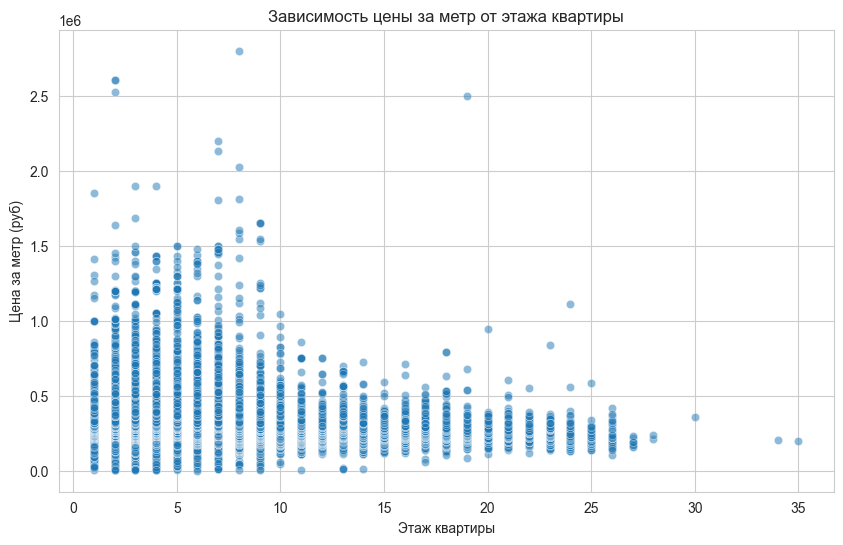

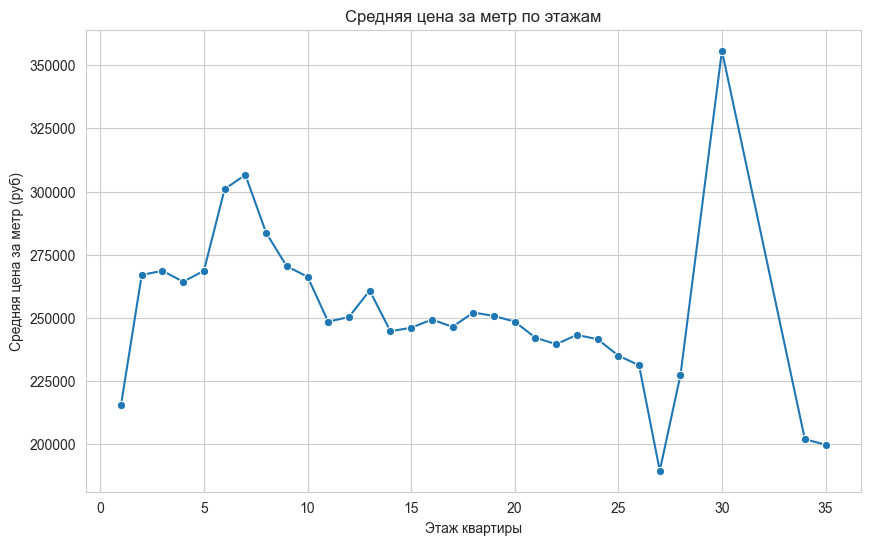

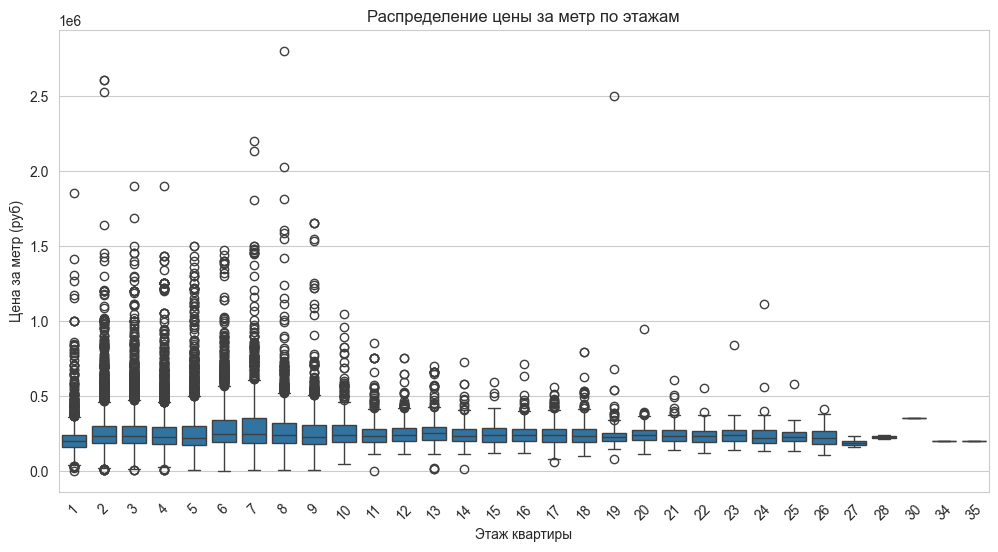

Корреляция Пирсона:
Коэффициент корреляции: -0.003
p-value: 0.650

Корреляция Спирмена:
Коэффициент корреляции: 0.099
p-value: 0.000

Тест Краскела-Уоллиса:
Статистика: 848.24
p-value: 0.000


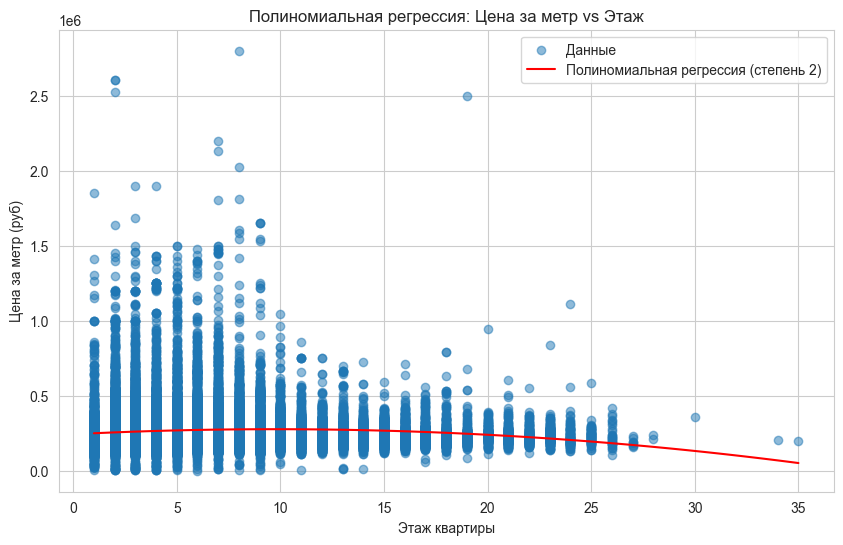


Коэффициенты полиномиальной регрессии:
Свободный член: 243609.51
Коэффициенты: [   0.         6897.07363688 -353.78809928]


In [45]:
# Предполагаем, что cian_tree — это твой датасет
# Убедимся, что 'Этаж_квартиры' — числовой столбец
cian_hyp = cian.copy()
cian_hyp['Этаж_квартиры'] = pd.to_numeric(cian_hyp['Этаж_квартиры'], errors='coerce')

# Удаляем строки с NaN в 'Этаж_квартиры' или 'Цена_за_метр'
cian_clean = cian_hyp.dropna(subset=['Этаж_квартиры', 'Цена_за_метр'])

# 1. Визуализация
# 1.1. Диаграмма рассеяния
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Этаж_квартиры', y='Цена_за_метр', data=cian_clean, alpha=0.5)
plt.title('Зависимость цены за метр от этажа квартиры')
plt.xlabel('Этаж квартиры')
plt.ylabel('Цена за метр (руб)')
plt.show()

# 1.2. Средняя цена за метр по этажам
mean_price_by_floor = cian_clean.groupby('Этаж_квартиры')['Цена_за_метр'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='Этаж_квартиры', y='Цена_за_метр', data=mean_price_by_floor, marker='o')
plt.title('Средняя цена за метр по этажам')
plt.xlabel('Этаж квартиры')
plt.ylabel('Средняя цена за метр (руб)')
plt.show()

# 1.3. Boxplot для распределения цен по этажам
plt.figure(figsize=(12, 6))
sns.boxplot(x='Этаж_квартиры', y='Цена_за_метр', data=cian_clean)
plt.title('Распределение цены за метр по этажам')
plt.xlabel('Этаж квартиры')
plt.ylabel('Цена за метр (руб)')
plt.xticks(rotation=45)
plt.show()

# 2. Статистические тесты
# 2.1. Корреляция Пирсона (линейная зависимость)
corr_pearson, pval_pearson = pearsonr(cian_clean['Этаж_квартиры'], cian_clean['Цена_за_метр'])
print("Корреляция Пирсона:")
print(f"Коэффициент корреляции: {corr_pearson:.3f}")
print(f"p-value: {pval_pearson:.3f}")

# 2.2. Корреляция Спирмена (монотонная зависимость)
corr_spearman, pval_spearman = spearmanr(cian_clean['Этаж_квартиры'], cian_clean['Цена_за_метр'])
print("\nКорреляция Спирмена:")
print(f"Коэффициент корреляции: {corr_spearman:.3f}")
print(f"p-value: {pval_spearman:.3f}")

# 2.3. Тест Краскела-Уоллиса (сравнение цен по этажам)
# Группируем данные по этажам
floor_groups = [cian_clean[cian_clean['Этаж_квартиры'] == floor]['Цена_за_метр'] for floor in cian_clean['Этаж_квартиры'].unique()]
# Убедимся, что все группы непустые
floor_groups = [group for group in floor_groups if len(group) > 0]
if len(floor_groups) > 1:
    kruskal_stat, kruskal_pval = kruskal(*floor_groups)
    print("\nТест Краскела-Уоллиса:")
    print(f"Статистика: {kruskal_stat:.2f}")
    print(f"p-value: {kruskal_pval:.3f}")
else:
    print("\nТест Краскела-Уоллиса не выполнен: недостаточно данных для сравнения.")

# 2.4. Полиномиальная регрессия (проверка нелинейной зависимости)
# Подготовим данные
X = cian_clean[['Этаж_квартиры']].values
y = cian_clean['Цена_за_метр'].values

# Полиномиальная регрессия (степень 2)
degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(X, y)

# Предсказания для визуализации
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = polyreg.predict(X_range)

# Визуализация полиномиальной регрессии
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='Данные')
plt.plot(X_range, y_pred, color='red', label=f'Полиномиальная регрессия (степень {degree})')
plt.title('Полиномиальная регрессия: Цена за метр vs Этаж')
plt.xlabel('Этаж квартиры')
plt.ylabel('Цена за метр (руб)')
plt.legend()
plt.show()

# Оценка значимости коэффициентов (для линейной регрессии)
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print("\nКоэффициенты полиномиальной регрессии:")
print(f"Свободный член: {lin_reg.intercept_:.2f}")
print(f"Коэффициенты: {lin_reg.coef_}")